# $\frac{dE}{d\eta}$ Model

## Training

In [1]:
import sys
sys.path.append('../hydroml')

from hydroml.model import DELinearModel, DEConvolutionModel
from hydroml.dataset import EnergyDensityDataset
from hydroml.utils import batch_trim, trim
from hydroml.plot import plot_cc_graph, plot_telemetry
import matplotlib.pyplot as plt
from torch import nn
from torch import tensor
from IPython import display

import numpy as np

import torch

In [2]:
dataset = EnergyDensityDataset('../Datasets/dE_data_3/dE_detas_initial', '../Datasets/dE_data_3/dET_deta_final').smooth().cosh().trim(-6.8,8).no_asymmetric()

[24, 38, 182, 224, 230, 254, 265, 350, 372, 414, 428, 469, 507, 530, 594, 607, 638, 658, 776, 781, 796, 800, 803, 809, 845, 853, 920, 1099, 1121, 1137, 1209, 1287, 1339, 1384, 1430, 1460, 1461, 1534, 1594, 1597, 1623, 1836, 1873, 1893, 2014, 2071, 2111, 2118, 2163, 2164, 2184, 2346, 2360, 2364, 2440, 2487, 2527, 2641, 2664, 2739, 2824, 2825, 2834, 2920, 2987, 3163, 3166, 3385, 3397, 3578, 3579, 3610, 3636, 3678, 3691, 3709, 3713, 3714, 3787, 3908, 3945, 3947, 3963, 4072, 4141, 4315, 4442, 4474, 4486, 4488, 4508, 4526, 4542, 4559, 4560, 4647, 4678, 4688, 4860, 4879, 4904, 4911, 4963, 5000, 5007, 5056, 5064, 5075, 5113, 5199, 5210, 5224, 5246, 5281, 5318, 5370, 5375, 5388, 5439, 5441, 5480, 5504, 5564, 5577, 5630, 5662, 5714, 5742, 5758, 5779, 5858, 5884, 5965, 5980, 5989, 6102, 6114, 6249, 6260, 6463, 6465, 6652, 6655, 6697, 6758, 6779, 6868, 6902, 6928, 6962, 6992, 7016, 7106, 7124, 7217, 7288, 7290, 7315, 7405, 7513, 7539, 7573, 7587, 7604, 7738, 7743, 7757, 7765, 7771, 7866, 7891, 79

In [3]:
batch_size = 64
epochs = 500
learning_rate = 1e-5
beta1 = 0.9

bound_1 = -4.9
bound_2 = 0.0

In [4]:
data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [5]:
dE_model = DEConvolutionModel()

In [6]:
optimizer = torch.optim.Adamax(dE_model.parameters(), lr=learning_rate)

In [7]:
loss_func = nn.MSELoss()

In [8]:
for epoch in range(epochs):
    for i, data in enumerate(data_loader):
        actual_batch_size = data[1].shape[0]

        etas_start = dataset.start_eta
        etas_final = dataset.final_eta
        dE_deta_initial = data[0].reshape(actual_batch_size, 1, len(dataset.start_eta))
        dNch_deta_final = data[1].reshape(actual_batch_size, 1, len(dataset.final_eta))

        optimizer.zero_grad()

        output = dE_model(dE_deta_initial.float())

        loss = loss_func(output, dNch_deta_final.float())

        loss.backward()
        optimizer.step()

        display.clear_output(wait=True)

        print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(dataset) // batch_size}], loss: {loss:.4f}")

Epoch [500/500], Batch [257/256], loss: 6.0509


In [9]:
torch.save(dE_model, '../Trained Models/dE_model.pt')

# Inference

In [2]:
dE_detas_model = torch.load('../Trained Models/dE_model.pt')
dE_detas_model.eval()

DEConvolutionModel(
  (conv1): Conv1d(1, 1, kernel_size=(17,), stride=(1,), padding=same, bias=False)
  (lin1): Linear(in_features=462, out_features=400, bias=False)
  (lin2): Linear(in_features=400, out_features=200, bias=False)
  (lin3): Linear(in_features=200, out_features=139, bias=False)
  (lin4): Linear(in_features=139, out_features=139, bias=False)
  (r): ReLU()
)

In [20]:
dataset = EnergyDensityDataset('../Datasets/dE_data_4/dE_detas_initial', '../Datasets/dE_data_4/dET_deta_final').smooth().cosh().trim(-6.8, 8).no_asymmetric()

[320, 368, 635, 947, 948, 1165, 1698, 2076, 2125, 2181, 2188, 2650, 2738, 2767, 2806, 2874, 3019, 3092, 3130, 3232, 3448, 3473, 3673, 3751, 3904, 4018, 4057, 4133, 4210, 4258, 4572, 4619, 4669, 4670, 5513, 5761, 5862, 6200, 6323, 6341, 6451, 6823]


In [21]:
data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    shuffle=True,
)

/var/folders/xc/y6t34tms1pv1hptzwlzrrscc0000gn/T/ipykernel_58880/811880218.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  final_data = np.array(final_data)
/var/folders/xc/y6t34tms1pv1hptzwlzrrscc0000gn/T/ipykernel_58880/811880218.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_data = np.array(final_data)


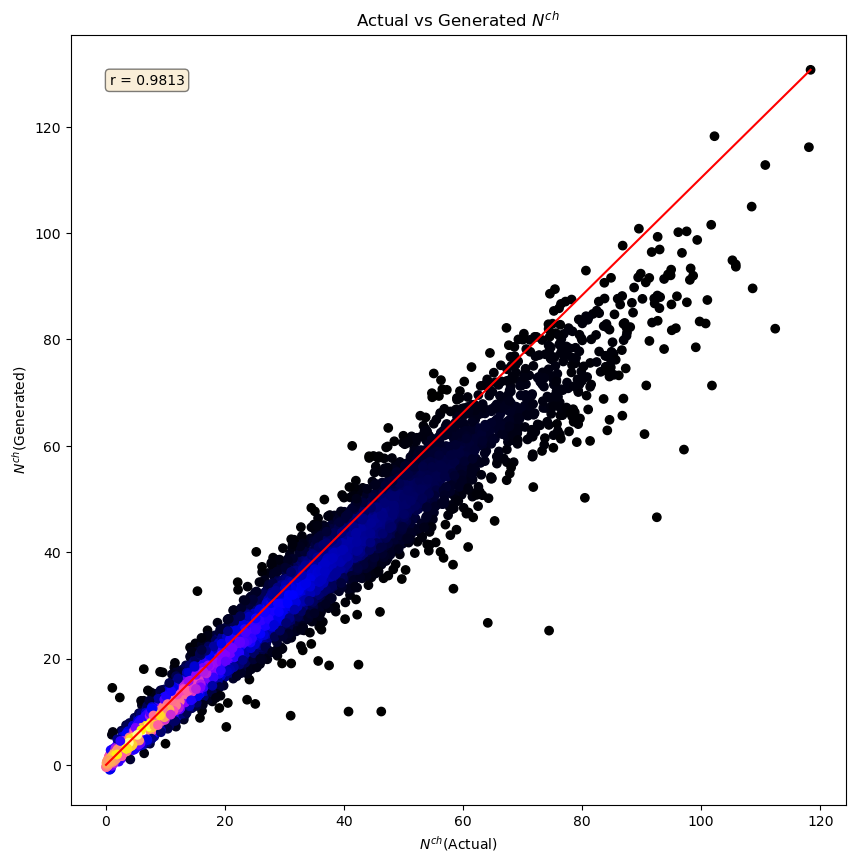

In [22]:
finals = []
models = []
outputs = []
output_data = []
final_data = []

for i, data in enumerate(data_loader):
    dE_detas_initial = data[0]
    dNch_detas_final = data[1].flatten()

    output = dE_detas_model(dE_detas_initial.float()).detach().numpy().flatten()

    outputs.append(output)
    output_data.append(output)
    final_data.append(dNch_detas_final)

    #Trim down the data to the section that we want.
    trim_final_axis, trim_final = trim(dataset.final_eta, dNch_detas_final, -4.9, -3.1)
    trim_generated_axis, trim_generated = trim(dataset.final_eta, output, -4.9, -3.1)

    integrated_final = np.trapz( trim_final, trim_final_axis )
    integrated_output = np.trapz( trim_generated, trim_generated_axis )

    if integrated_final > 150:
        print(i)

    finals.append( integrated_final )
    models.append( integrated_output )

finals = np.array(finals)
models = np.array(models)
outputs = np.array(outputs)

output_data = np.array(output_data)
final_data = np.array(final_data)

plot_cc_graph(finals, models)

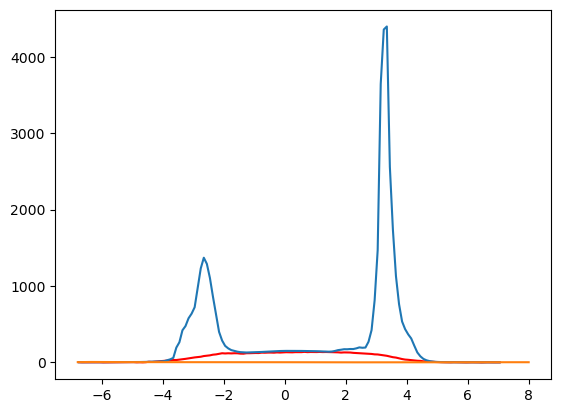

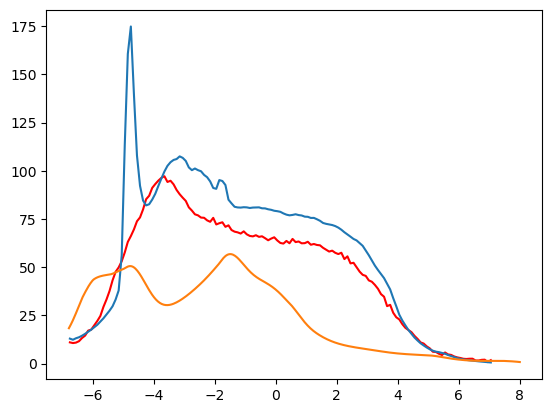

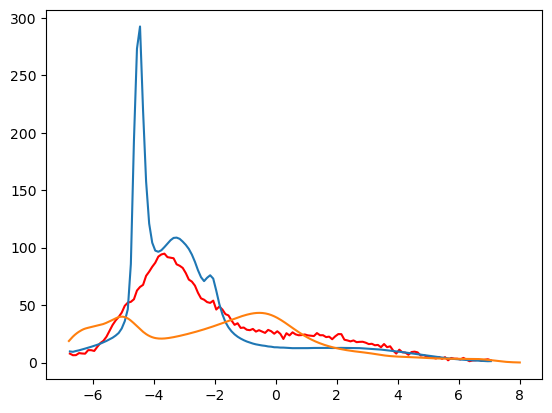

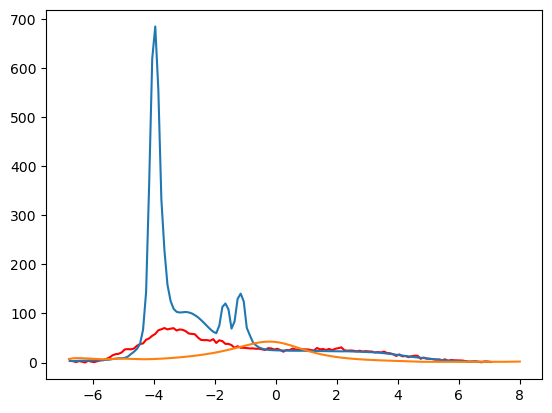

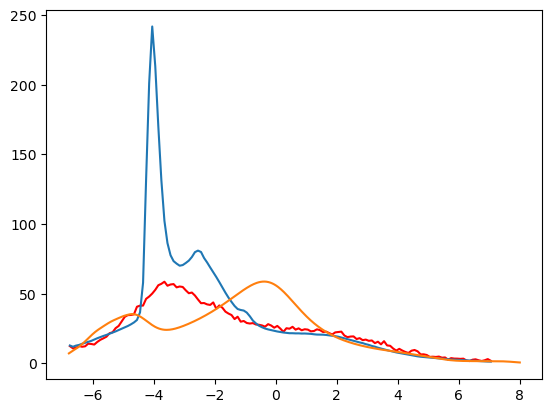

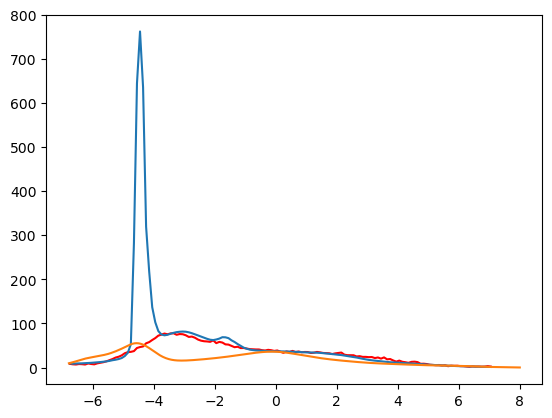

In [19]:
asymmetric = [3018,
3894,
5753,
6284,
6535,
7001]

for i in asymmetric:
    fig = plt.figure()
    plt.plot(dataset.final_eta, output_data[i], color='red')
    plt.plot(dataset.final_eta, final_data[i])
    plt.plot(dataset.start_eta, dataset.initial[i])
    plt.show()